# **Classification d’images de globules blancs**
**Analyse Comparée de Modèles pour la Classification des Images de Globules Blancs**


Les globules blancs, ou leucocytes, sont des cellules essentielles du système immunitaire, responsables de la défense de l'organisme contre les infections et les maladies. Parmi eux, plusieurs sous-types – les lymphocytes, les monocytes, les neutrophiles et les éosinophiles – remplissent des fonctions distinctes dans la réponse immunitaire. Leur classification précise est importante pour diagnostiquer diverses pathologies du sang, y compris les infections, les maladies inflammatoires et certains cancers. Toutefois, cette tâche, réalisée manuellement, est souvent complexe, chronophage, et sujette aux erreurs humaines.

Ce projet vise à automatiser cette classification en utilisant des techniques d’apprentissage automatique, afin d’améliorer à la fois la vitesse et l’exactitude des diagnostics. Trois modèles principaux ont été testés : un modèle de forêt aléatoire (Random Forest), un réseau de neurones convolutif (CNN) personnalisé, et une version fine-tunée de VGG16. Ces modèles ont été évalués pour déterminer celui qui offre les meilleures performances pour la classification des images de globules blancs.

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
import cv2
import numpy as np
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import collections
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.applications import VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

2025-09-16 10:00:18.231800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758016818.581779      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758016818.673430      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. DONNÉES

Les données utilisées pour ce projet proviennent de la plateforme Kaggle et se composent de 12 500 images de globules blancs. Ces images sont accompagnées de labels, chaque globule blanc étant pré-classé dans l'une des quatre catégories principales : 
* **Lymphocyte** : Petit avec un noyau sombre rond et peu de cytoplasme visible. Il joue un rôle clé dans l'immunité en ciblant spécifiquement les agents pathogènes via des réponses adaptatives.
* **Monocyte** : Grand avec un noyau en forme de haricot. Cette cellule se transforme en macrophage pour engloutir et éliminer les agents pathogènes et les cellules mortes.
* **Éosinophile** : Noyau bilobé avec des granules rougeâtres. Elle intervient dans la défense contre les parasites et dans les réactions allergiques en libérant des substances inflammatoires.
* **Neutrophile** : Noyau multilobé (souvent 3-5 lobes) avec cytoplasme granuleux. C’est la première ligne de défense de l’organisme, détruisant les bactéries par phagocytose.

Chaque type de cellule présente des caractéristiques visuelles distinctes, ce qui permet une analyse précise par les modèles d’apprentissage. 

**Remarque** : Les monocytes et les neutrophiles se ressemblent par leur grande taille et leur cytoplasme granuleux, ce qui peut entraîner une confusion dans les modèles de classification ; cette similarité morphologique constitue une difficulté à prendre en compte pour améliorer la précision des modèles de reconnaissance cellulaire.

Dans un premier temps, il est nécessaire d'importer les données et de les visualiser

## 1.1 importation et visualisation

In [4]:
# Chemin vers le dossier TRAIN dans dataset2-master
train_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/'

# Types de cellules (classes)
classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

# Initialisation des listes pour stocker les images et les labels
train_images = []
train_labels = []

# Parcourir chaque dossier de classe
for cell_type in classes:
    cell_dir = os.path.join(train_dir, cell_type)
    for img_file in os.listdir(cell_dir):
        img_path = os.path.join(cell_dir, img_file)
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normaliser les pixels

        # Ajouter l'image et le label à leurs listes respectives
        train_images.append(img_array)
        train_labels.append(cell_type)

# Convertir les listes en tableaux numpy
train_images = np.array(train_images)
train_labels = np.array(train_labels)

print(f"Nombre d'images chargées pour l'entraînement : {train_images.shape[0]}")
print(f"Dimensions des images : {train_images.shape[1:]}")

Nombre d'images chargées pour l'entraînement : 9957
Dimensions des images : (128, 128, 3)


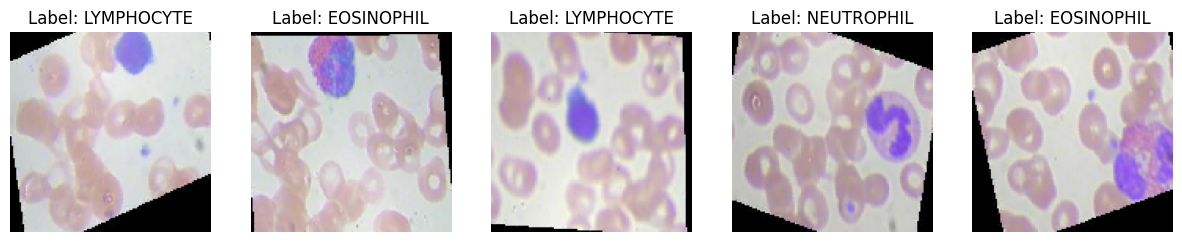

In [5]:
# Encoder les labels textuels en labels numériques pour l'affichage
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(train_labels)

# Afficher les 5 images aléatoires avec leurs labels
random_indices = random.sample(range(train_images.shape[0]), 5)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_images[idx])
    plt.title(f"Label: {encoder.inverse_transform([encoded_labels[idx]])[0]}")
    plt.axis('off')
plt.show()

On remarque que les images ne sont pas bien dimensionnées, ce qui pourrait affecter la qualité de l'analyse. Il est donc nécessaire de les prétraiter pour uniformiser leurs dimensions avant de procéder à l’entrainement de modèles.

In [6]:
# Encodage des labels en valeurs numériques
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

print(train_labels_encoded[:10])

[0 0 0 0 0 0 0 0 0 0]


In [7]:
print(train_labels[:10])

# Distribution des labels avant encodage
import collections
print(collections.Counter(train_labels))

['EOSINOPHIL' 'EOSINOPHIL' 'EOSINOPHIL' 'EOSINOPHIL' 'EOSINOPHIL'
 'EOSINOPHIL' 'EOSINOPHIL' 'EOSINOPHIL' 'EOSINOPHIL' 'EOSINOPHIL']
Counter({'NEUTROPHIL': 2499, 'EOSINOPHIL': 2497, 'LYMPHOCYTE': 2483, 'MONOCYTE': 2478})


Ici, on peut voir la représentation des différentes classes de cellules, avec un nombre équilibré pour chaque type. Cela montre une répartition relativement uniforme dans l’ensemble des données.

## 1.2 augmentation des données

Pour redimensionner les images et normaliser les zones d'intérêt, on utilise une série de fonctions. La fonction **findEdges(image)** identifie d'abord les contours principaux de l'image en réduisant le bruit, puis en appliquant la détection de contours. Ensuite, **getImgContours(edged)** trie ces contours par taille, et **extractBoundingBoxes(contours, image)** génère des boîtes englobantes autour de chaque contour pertinent, ce qui permet d’isoler et de redimensionner les zones significatives dans l'image pour une meilleure classification.

In [8]:
def findEdges(image):
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    gray = cv2.bilateralFilter(gray, 9, 75, 75)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

def getImgContours(edged):
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

def extractBoundingBoxes(contours, image):
    boxes = []
    for contour in contours:
        rect = cv2.minAreaRect(contour)
        points = cv2.boxPoints(rect)  
        points = np.array(points, dtype="int")
        
        top_left, top_right, bottom_right, bottom_left = points
        if dist.euclidean(top_left, bottom_left) > 0 and dist.euclidean(top_left, top_right) > 0:
            boxes.append(points)
    return boxes

In [9]:
def previewImageTransformations(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[198, 203, 208])

    plt.imshow(img)
    plt.title('Original Image')
    plt.show()

    masked_img = cv2.inRange(img, (80, 80, 180), (180, 170, 245))
    
    kernel_small = np.ones((3, 3), np.uint8)
    kernel_large = np.ones((5, 5), np.uint8)
    eroded = cv2.erode(masked_img, kernel_small, iterations=2)
    masked_img = cv2.dilate(eroded, kernel_large, iterations=5)

    plt.imshow(masked_img, cmap='gray')
    plt.title('Thresholded and Cleaned Image')
    plt.show()

    edges = findEdges(masked_img)
    contours = getImgContours(edges)
    boxes = extractBoundingBoxes(contours, img.copy())

    if boxes:
        largest_box = boxes[-1]
        max_x, min_x = int(max(largest_box[:, 0])), int(min(largest_box[:, 0]))
        max_y, min_y = int(max(largest_box[:, 1])), int(min(largest_box[:, 1]))

        mask = np.zeros_like(img)
        cv2.drawContours(mask, contours, len(contours) - 1, (255, 255, 255), -1)
        img[mask == 0] = 0

        plt.imshow(img)
        plt.title('Masked Image with Detected Contours')
        plt.show()

        img_with_contours = img.copy()
        cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 1)
        plt.imshow(img_with_contours)
        plt.title('Image with Contours Highlighted')
        plt.show()

        cropped_img = img[min_y:max_y, min_x:max_x]
        
        plt.imshow(cropped_img)
        plt.title('Cropped Image')
        plt.show()


Nous procédons à un test sur une ou plusieurs images avant de l'appliquer sur l'ensemble de nos données.

In [10]:
def plotRandomImageBeforeAndAfter(folder_path):
    if not os.path.isdir(folder_path):
        print(f"Le dossier spécifié n'existe pas : {folder_path}")
        return
    
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print("Aucun fichier d'image trouvé dans le dossier spécifié.")
        return
    
    random_image_path = os.path.join(folder_path, random.choice(image_files))

    original_img = cv2.imread(random_image_path)
    if original_img is None:
        print(f"Impossible de charger l'image : {random_image_path}")
        return
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img_rgb)
    plt.title("Original Image")
    plt.axis("off")

    img = original_img_rgb.copy()
    img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[198, 203, 208])

    masked_img = cv2.inRange(img, (80, 80, 180), (180, 170, 245))
    kernel_small = np.ones((3, 3), np.uint8)
    kernel_large = np.ones((5, 5), np.uint8)
    eroded = cv2.erode(masked_img, kernel_small, iterations=2)
    masked_img = cv2.dilate(eroded, kernel_large, iterations=5)

    edges = findEdges(masked_img)
    contours = getImgContours(edges)
    boxes = extractBoundingBoxes(contours, img.copy())

    if boxes:
        largest_box = boxes[-1]
        max_x, min_x = int(max(largest_box[:, 0])), int(min(largest_box[:, 0]))
        max_y, min_y = int(max(largest_box[:, 1])), int(min(largest_box[:, 1]))

        mask = np.zeros_like(img)
        cv2.drawContours(mask, contours, len(contours) - 1, (255, 255, 255), -1)
        img[mask == 0] = 0
        cropped_img = img[min_y:max_y, min_x:max_x]
        final_img = cropped_img if cropped_img.size != 0 else img
    else:
        final_img = img

    plt.subplot(1, 2, 2)
    plt.imshow(final_img)
    plt.title("Processed Image")
    plt.axis("off")
    plt.show()


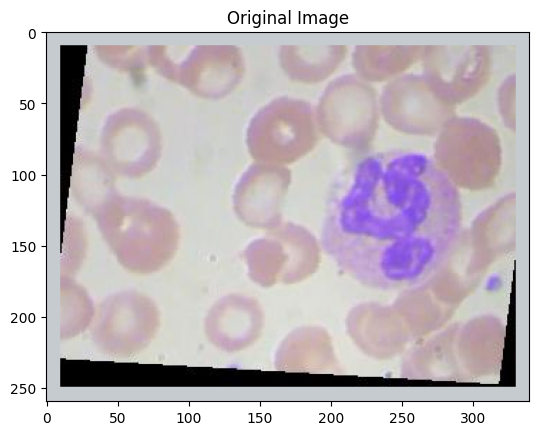

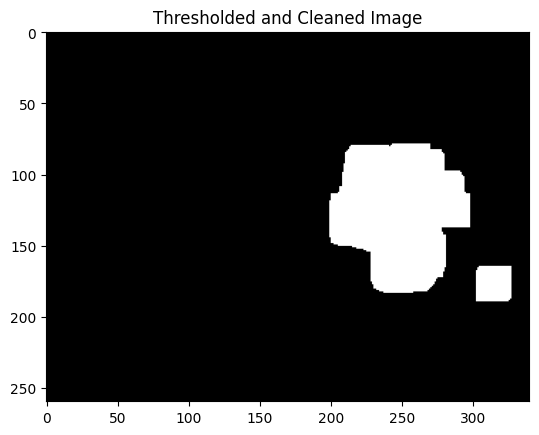

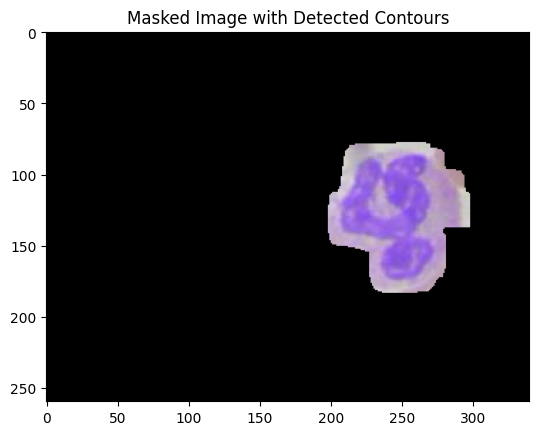

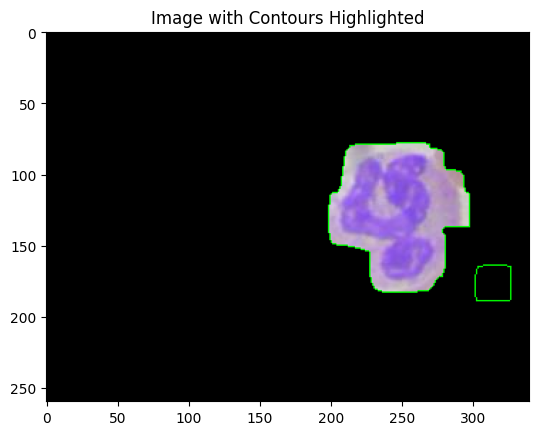

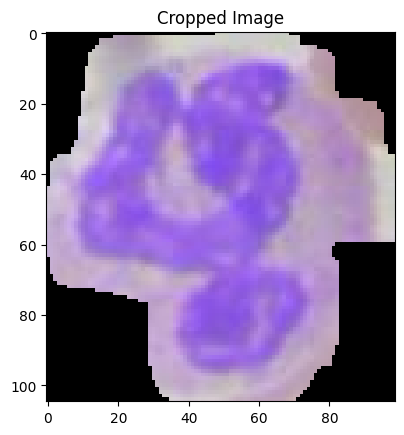

In [11]:
train_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL'

image_path = os.path.join(train_dir, random.choice(os.listdir(train_dir)))

previewImageTransformations(image_path)


Nous pouvons donc procéder à l'augmentations de nos données. Il est préferable de créer un nouveau dossier afin de stocker nos images traitées.

In [12]:
def overwriteImagesInNewFolders(folder_path):
    processed_images = os.path.join(os.getcwd(), "processed_images")
    
    # Créer des répertoires dans "processed_images"
    cell_types = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]
    cell_paths = {cell_type: os.path.join(processed_images, cell_type) for cell_type in cell_types}
    
    for path in cell_paths.values():
        os.makedirs(path, exist_ok=True)

    # Traiter chaque dossier de type de cellule dans le dossier principal
    for cell_type in cell_types:
        cell_folder_path = os.path.join(folder_path, "TRAIN", cell_type)
        
        if not os.path.isdir(cell_folder_path):
            print(f"Dossier non trouvé : {cell_folder_path}")
            continue

        # Itérer sur chaque image dans le dossier du type de cellule
        for filename in os.listdir(cell_folder_path):
            image_path = os.path.join(cell_folder_path, filename)
            
            if not (filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png')):
                continue
            
            # Charger et ajouter une bordure à l'image originale
            img = cv2.imread(image_path)
            if img is None:
                continue
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[198, 203, 208])
            
            # Seuillage et nettoyage
            masked_img = cv2.inRange(img, (80, 80, 180), (180, 170, 245))
            kernel_small = np.ones((3, 3), np.uint8)
            kernel_large = np.ones((5, 5), np.uint8)
            eroded = cv2.erode(masked_img, kernel_small, iterations=2)
            masked_img = cv2.dilate(eroded, kernel_large, iterations=5)

            # Détection des contours et extraction
            edges = findEdges(masked_img)
            contours = getImgContours(edges)
            boxes = extractBoundingBoxes(contours, img.copy())

            # S'il y a des contours, obtenir la plus grande boîte englobante et recadrer
            if boxes:
                largest_box = boxes[-1]
                max_x, min_x = int(max(largest_box[:, 0])), int(min(largest_box[:, 0]))
                max_y, min_y = int(max(largest_box[:, 1])), int(min(largest_box[:, 1]))

                mask = np.zeros_like(img)
                cv2.drawContours(mask, contours, len(contours) - 1, (255, 255, 255), -1)
                img[mask == 0] = 0

                # Recadrer l'image en fonction de la boîte englobante
                cropped_img = img[min_y:max_y, min_x:max_x]
                
                # Sauvegarder l'image recadrée ou l'image masquée si le recadrage est vide
                final_img = cropped_img if cropped_img.size != 0 else img
            else:
                final_img = img  # Revenir à l'image avec bordure et masquée si aucun contour n'est trouvé

            # Convertir l'image finale en BGR et l'enregistrer dans le nouveau répertoire
            save_image_path = os.path.join(cell_paths[cell_type], filename)
            cv2.imwrite(save_image_path, cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR))
    
    print("Toutes les images ont été traitées et enregistrées dans le dossier 'processed_images'.")

    
    
overwriteImagesInNewFolders('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images')


Toutes les images ont été traitées et enregistrées dans le dossier 'processed_images'.


Afin de s'assurer que le traitement a bien effectué, nous affichons une cellule de chaque dossier.

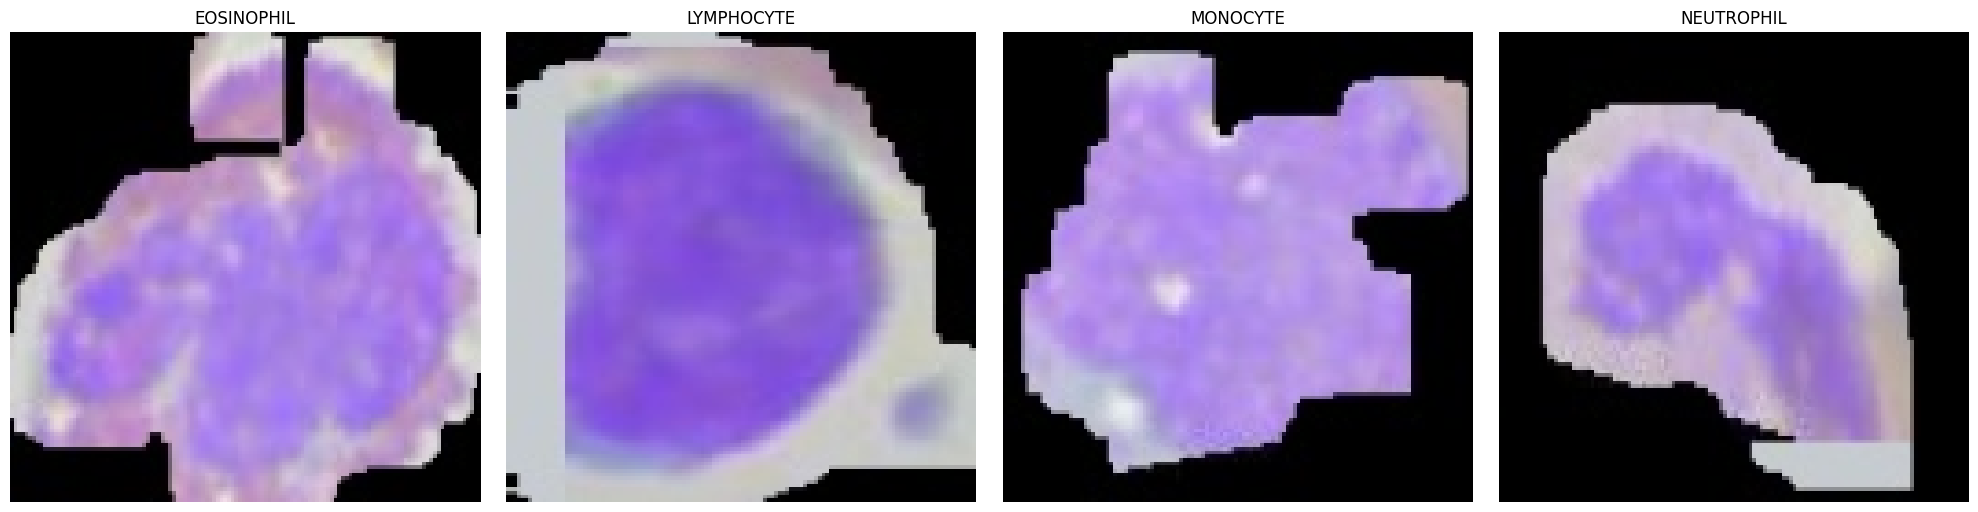

In [13]:
# Chemin vers les images traitées
processed_images_dir = os.path.join(os.getcwd(), "processed_images")
list_cells = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]

# Afficher une image traitée par type de cellule avec un recadrage
fig, axes = plt.subplots(1, len(list_cells), figsize=(20, 5))

for i, cell_type in enumerate(list_cells):
    path = os.path.join(processed_images_dir, cell_type)
    files = os.listdir(path)
    
    # Vérifier qu'il y a au moins un fichier dans le dossier
    if files:
        image_path = os.path.join(path, files[0])
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Redimensionner à une taille fixe pour améliorer la visibilité (optionnel)
        display_img = cv2.resize(image_rgb, (128, 128), interpolation=cv2.INTER_AREA)
        
        axes[i].imshow(display_img)
        axes[i].set_title(cell_type)
        axes[i].axis("off")
    else:
        axes[i].text(0.5, 0.5, "Aucune image", ha="center", va="center")
        axes[i].set_title(cell_type)
        axes[i].axis("off")

plt.tight_layout()
plt.show()


Nous pouvons voir que nos cellules ont bien étaient découpées. Ceci facilitera la classification de nos modèles

Nous divisons les données en deux ensembles, avec 80 % pour l’entraînement et 20 % pour la validation, afin de préparer le modèle à une classification efficace et de garantir une bonne représentativité des classes. Ensuite, les étiquettes sont encodées pour représenter les 4 classes de cellules, assurant une compatibilité avec le modèle, et les dimensions de chaque ensemble sont confirmées pour garantir leur bonne structuration.

In [14]:
processed_images_dir = "processed_images"  # Mettre à jour si nécessaire
list_cells = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]

images = []
labels = []

# Définir une taille commune pour toutes les images
target_size = (128, 128)

# Charger les images et assigner des labels basés sur les noms des dossiers
for label, cell_type in enumerate(list_cells):
    path = os.path.join(processed_images_dir, cell_type)
    for filename in os.listdir(path):
        image_path = os.path.join(path, filename)
        img = cv2.imread(image_path)
        
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en format RGB
            img = cv2.resize(img, target_size)  # Redimensionner à 128x128
            images.append(img)
            labels.append(label)  # Label basé sur le dossier

# Convertir les listes en tableaux numpy
images = np.array(images)
labels = np.array(labels)

In [15]:
# Séparer le jeu de données en 80% données d'entrainement et 20% données de validation
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Encodage one-shot
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

print(f"Training data dimensions: {X_train.shape}")
print(f"Training labels dimensions: {y_train.shape}")
print(f"Validation data dimensions: {X_val.shape}")
print(f"Validation labels dimensions: {y_val.shape}")

Training data dimensions: (7965, 128, 128, 3)
Training labels dimensions: (7965, 4)
Validation data dimensions: (1992, 128, 128, 3)
Validation labels dimensions: (1992, 4)


# 2 MÉTHODES

Nous avons utilisé trois modèles pour aborder cette tâche de classification des cellules :

* **Random Forest** : choisi pour sa capacité à bien capturer des motifs et des relations dans les données, offrant une première baseline robuste.
* **VGG16 fine-tuné** : sélectionné pour tirer parti d'un modèle pré-entrainé sur une large base d'images, capable de capturer des caractéristiques visuelles complexes spécifiques aux cellules tout en étant ajusté pour notre dataset.
* **CNN personnalisé** : développé pour s’adapter aux spécificités de notre ensemble de données, avec une architecture optimisée pour identifier efficacement les caractéristiques visuelles des cellules.


Chaque modèle apporte une approche différente, permettant d'explorer diverses méthodes pour maximiser la précision de la classification.

## 2.1 RANDOM FOREST

Nous avons configuré notre modèle Random Forest avec 100 arbres (n_estimators=100) et un état aléatoire fixé (random_state=42) pour assurer la reproductibilité des résultats.

### Initialisation et entrainement du modèle

In [16]:
# Aplatir les images pour les rendre compatibles avec Random Forest
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_val_rf = X_val.reshape(X_val.shape[0], -1)        

# Initialiser et entraîner le modèle à 100 arbres
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train)

RandomForestClassifier(random_state=42)

### Evaluation du modèle

Ensuite nous procédonc à l'évaluation de notre modèle par la prédiction sur l'ensemble de validation. Nous choisissons de nous concentrer sur deux types d'évaluation : 
* le rapport de classification
* la matrice de confusion

In [17]:
# Évaluer le modèle
accuracy = rf_model.score(X_val_rf, y_val)
print(f"Accuracy du modèle Random Forest: {accuracy:.2f}")

Accuracy du modèle Random Forest: 0.79


In [18]:
# Prédire sur l'ensemble de validation
y_pred_rf = rf_model.predict(X_val_rf)

# Évaluer les performances
accuracy = accuracy_score(y_val, y_pred_rf)
print(f"Accuracy du Random Forest : {accuracy:.2f}")

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_val, y_pred_rf, target_names=encoder.classes_, zero_division=1))

Accuracy du Random Forest : 0.79
Rapport de classification :
              precision    recall  f1-score   support

  EOSINOPHIL       0.96      0.67      0.79       509
  LYMPHOCYTE       0.99      0.97      0.98       506
    MONOCYTE       1.00      0.92      0.96       488
  NEUTROPHIL       0.94      0.60      0.73       489

   micro avg       0.98      0.79      0.87      1992
   macro avg       0.97      0.79      0.86      1992
weighted avg       0.97      0.79      0.86      1992
 samples avg       0.98      0.79      0.79      1992



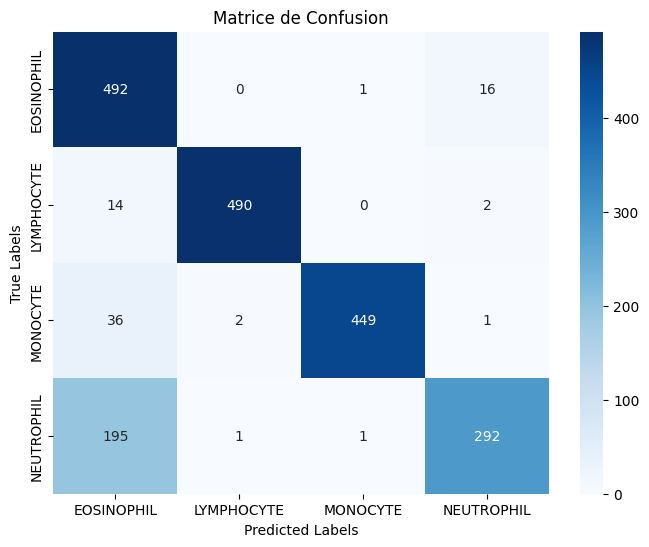

In [19]:
# Convertir en labels simples
if len(y_val.shape) > 1 and y_val.shape[1] > 1: 
    y_val = np.argmax(y_val, axis=1)
if len(y_pred_rf.shape) > 1 and y_pred_rf.shape[1] > 1:
    y_pred_rf = np.argmax(y_pred_rf, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_val, y_pred_rf)

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Matrice de Confusion")
plt.show()

Le rapport de classification montre une bonne précision globale, surtout pour les classes lymphocyte et monocyte, avec des scores F1 élevés. Cependant, les classes éosinophile et neutrophile ont un rappel plus bas (0.66 et 0.63 respectivement), indiquant que le modèle a plus de mal à les identifier correctement. Le modèle atteint une précision globale satisfaisante et est relativement rapide, mais il ne parvient pas à capturer toute la complexité de nos données, en particulier pour ces deux classes.

A noter : Nous avons entrainé notre random forest sur des images sans caractéristique particulière extraite, mais on aurait pu avoir de meilleurs résultats en extrayant des caractéristiques comme la couleur et/ou la granulosité et entrainer notre modèle dessus.

## 2.2 VGG16

Nous avons intégré le modèle **VGG16** pour enrichir notre approche de classification des cellules. Ce modèle de convolution profonde est bien adapté pour l'extraction de caractéristiques complexes dans les images, grâce à son architecture robuste pré-entrainée (bien que dans notre cas, les poids soient initialisés à zéro). Voici les étapes d'adaptation :

1. **Configuration de l'architecture** : Nous avons chargé VGG16 sans sa couche supérieure (`include_top=False`) et adapté la taille d’entrée des images à `(128, 128, 3)`. Les couches de VGG16 ont été **gelées** pour empêcher leur ajustement durant l'entraînement, permettant au modèle de s'appuyer sur des caractéristiques visuelles générales extraites par VGG16.

2. **Ajout de couches personnalisées** : Nous avons ajouté plusieurs couches entièrement connectées pour permettre au modèle de se concentrer sur les spécificités des images de cellules. Cela inclut des couches de normalisation, de dropout pour réduire le surapprentissage, et des couches denses avec la fonction d'activation `relu`.

3. **Configuration de l'optimisation** : Le modèle est compilé avec l'optimiseur `adam`, et la **fonction de perte `categorical_crossentropy`** est utilisée pour la classification des quatre classes.

4. **Réduction du taux d'apprentissage** : Nous avons défini une callback `ReduceLROnPlateau` pour ajuster dynamiquement le taux d'apprentissage en fonction de la validation, permettant une convergence plus stable.

Enfin, le modèle est entraîné avec un ensemble d’entraînement et un ensemble de validation, avec un total de 30 époques et une taille de batch de 32, pour une optimisation adaptée aux spécificités de notre jeu de données.

### Initialisation du modèle

In [20]:
# Vérifier que les labels ont la bonne shape pour le modèle
if len(y_train.shape) > 1:
    y_train_fixed = np.argmax(y_train, axis=-1) 
else:
    y_train_fixed = y_train

if len(y_val.shape) > 1:
    y_val_fixed = np.argmax(y_val, axis=-1) 
else:
    y_val_fixed = y_val

# one-hot encoding
y_train_one_hot = to_categorical(y_train_fixed, num_classes=4)
y_val_one_hot = to_categorical(y_val_fixed, num_classes=4)

In [21]:
# NE PAS OUBLIER DE TURN ON INTERNET 

# Chargement du modèle VGG16 pré-entraîné
vgg16_model = VGG16(
    include_top=False, 
    weights='imagenet', 
    input_shape=(128, 128, 3)
)

# Geler toutes les couches de VGG16
for layer in vgg16_model.layers:
    layer.trainable = False

# Construction du modèle
input_layer = Input(shape=(128, 128, 3))
x = vgg16_model(input_layer)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.7)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(4, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compilation du modèle
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True, 
    verbose=1
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    factor=0.3, 
    min_lr=1e-6, 
    verbose=1
)



I0000 00:00:1758017119.474323      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758017119.474941      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Entrainement du modèle

In [22]:
history = model.fit(
    X_train,
    y_train_one_hot, 
    validation_data=(X_val, y_val_one_hot), 
    batch_size=32, 
    epochs=15, 
    callbacks=[early_stopping, learning_rate_reduction]
)

Epoch 1/15


I0000 00:00:1758017126.353936      90 service.cc:148] XLA service 0x7a3070186280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758017126.355263      90 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758017126.355282      90 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758017126.957652      90 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/249 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.2569 - loss: 2.1351

I0000 00:00:1758017134.874987      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.4423 - loss: 1.3389 - val_accuracy: 0.7495 - val_loss: 0.5786 - learning_rate: 0.0010
Epoch 2/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.6704 - loss: 0.7650 - val_accuracy: 0.8168 - val_loss: 0.4347 - learning_rate: 0.0010
Epoch 3/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.7600 - loss: 0.5743 - val_accuracy: 0.8524 - val_loss: 0.3713 - learning_rate: 0.0010
Epoch 4/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.7999 - loss: 0.4829 - val_accuracy: 0.8805 - val_loss: 0.3259 - learning_rate: 0.0010
Epoch 5/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.8281 - loss: 0.4393 - val_accuracy: 0.8941 - val_loss: 0.2924 - learning_rate: 0.0010
Epoch 6/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.8465 - loss: 0.3922 - val_accuracy: 0.8991 - val_loss: 0.2896 - learning_rate: 0.0010
Epoch 7/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.8572 - loss: 0.358

### Evaluation du modèle

Nous procédons à l'évaluation du modèle en traçant les courbes d'accuracy et de perte pour l’entraînement et la validation, ce qui permet de suivre la convergence au fil des époques. Nous évaluons les performances finales du modèle sur l'ensemble de validation en affichant la perte et l'accuracy obtenues. Enfin, nous affichons la matrice de confusion issue de notre modèle.

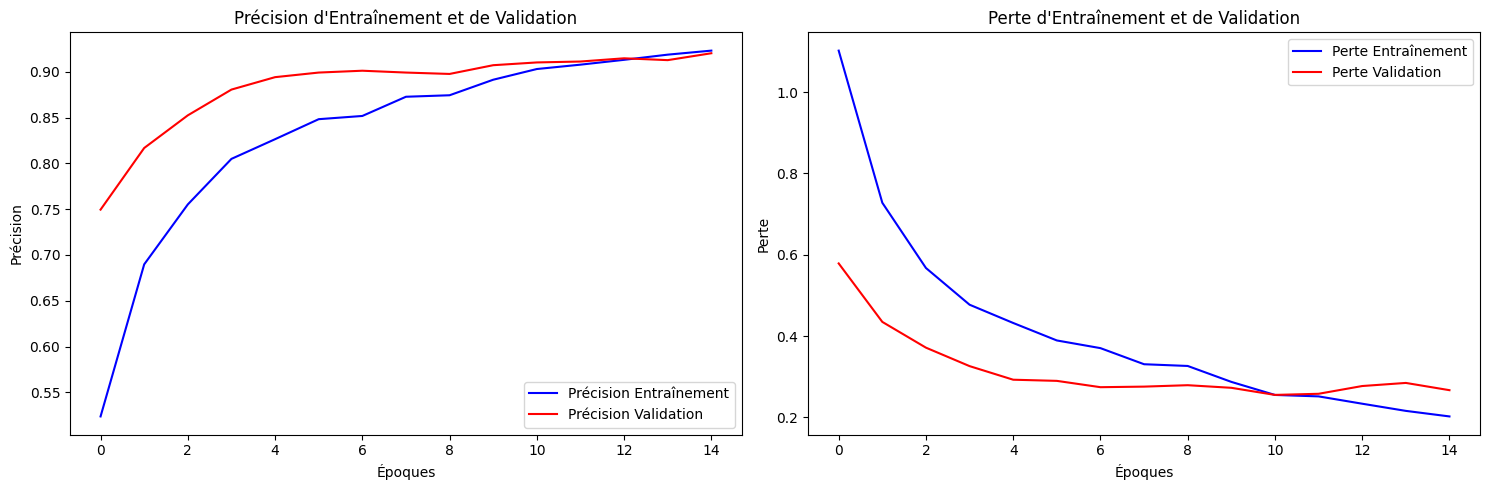

In [23]:
# Obtenir la précision et la perte et le nb d'epoch à partir de l'historique d'entraînement
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Tracer la précision d'entraînement et de validation sur le premier sous-graphe
axes[0].plot(epochs, train_accuracy, 'b', label='Précision Entraînement')
axes[0].plot(epochs, val_accuracy, 'r', label='Précision Validation')
axes[0].set_title('Précision d\'Entraînement et de Validation')
axes[0].set_xlabel('Époques')
axes[0].set_ylabel('Précision')
axes[0].legend()

# Tracer la perte d'entraînement et de validation sur le deuxième sous-graphe
axes[1].plot(epochs, train_loss, 'b', label='Perte Entraînement')
axes[1].plot(epochs, val_loss, 'r', label='Perte Validation')
axes[1].set_title('Perte d\'Entraînement et de Validation')
axes[1].set_xlabel('Époques')
axes[1].set_ylabel('Perte')
axes[1].legend()

# Affichage
plt.tight_layout()
plt.show()


In [24]:
# Évaluer le modèle sur l'ensemble de validation
val_loss, val_accuracy = model.evaluate(X_val, y_val_one_hot)
print(f"Loss sur validation : {val_loss}")
print(f"Accuracy sur validation : {val_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9035 - loss: 0.2602
Loss sur validation : 0.2550407350063324
Accuracy sur validation : 0.9101405739784241


In [25]:
# Obtenir les prédictions pour les données de validation
y_pred = model.predict(X_val)

# Convertir les valeurs prédites en labels de classe
y_pred_labels = np.argmax(y_pred, axis=1)

# Convertir les labels réels (one-hot encodés) en labels de classes
y_true = np.argmax(y_val_one_hot, axis=1)

# Générer le rapport de classification
report = classification_report(y_true, y_pred_labels, target_names=["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"])

print(report)


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step
              precision    recall  f1-score   support

  EOSINOPHIL       0.87      0.81      0.84       509
  LYMPHOCYTE       0.99      0.99      0.99       506
    MONOCYTE       0.96      0.98      0.97       488
  NEUTROPHIL       0.82      0.86      0.84       489

    accuracy                           0.91      1992
   macro avg       0.91      0.91      0.91      1992
weighted avg       0.91      0.91      0.91      1992



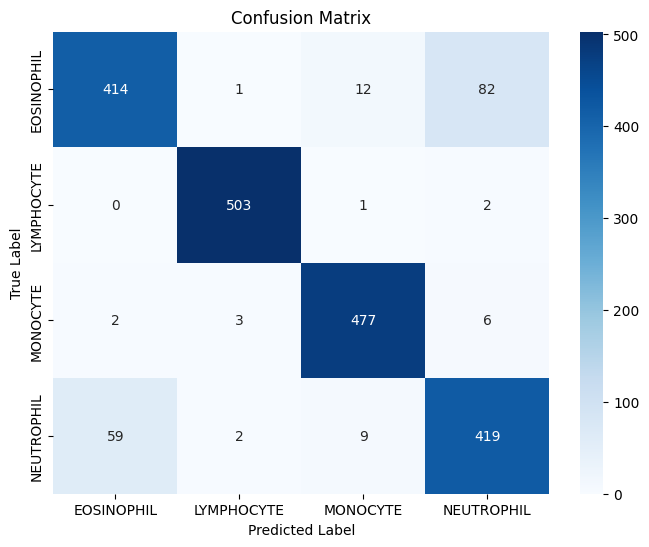

In [26]:
# Générer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_labels)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], 
    yticklabels=['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


La précision et la perte en entraînement et validation montrent une convergence stable. Le rapport de classification révèle une performance acceptable avec une précision de 91% au global, bien que les scores F1 pour les classes éosinophile (0.84) et neutrophile (0.85) soient plus faibles, signalant des difficultés dans leur identification. La matrice de confusion confirme ces faiblesses, montrant des erreurs de classification fréquentes pour ces deux classes, ce qui réduit la performance globale du modèle.

## 2.3 CNN PERSONNALISÉ

Nous avons conçu un modèle de **réseau de neurones convolutionnel (CNN) personnalisé** pour améliorer notre approche de classification des cellules sanguines. Ce modèle est spécialement adapté pour extraire des caractéristiques pertinentes des images, grâce à une architecture optimisée pour notre jeu de données. Voici les étapes de conception et de configuration de notre modèle :

1. **Configuration de l'architecture** : Nous avons construit un CNN comprenant plusieurs couches convolutionnelles utilisant des kernels de taille `(3, 3)` standard et la fonction d'activation `relu`. La taille d'entrée des images a été fixée à `(128, 128, 3)` pour correspondre à nos données prétraitées. Des couches de batch normalization et de max pooling ont été intégrées pour améliorer la convergence et réduire le surapprentissage.

2. **Configuration de l'optimisation** : Le modèle est compilé avec l'optimiseur `SGD` (Stochastic Gradient Descent) et la **fonction de perte `categorical_crossentropy`** est utilisée pour la classification des quatre classes de cellules sanguines.

3. **Entraînement du modèle** : Le modèle est entraîné sur un ensemble d'entraînement et validé sur un ensemble de validation, sur un total de 10 époques, avec une taille de batch appropriée pour optimiser l'efficacité de l'apprentissage.

### Initialisation du modèle

In [27]:
model = keras.models.Sequential([
    # Première couche convolutionnelle
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(128, 128, 3), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    # Deuxième couche convolutionnelle
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    # Troisième couche convolutionnelle
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    # 4ème couche convolutionnelle
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    # 5ème couche convolutionnelle
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    # Couches entièrement connectées
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

In [29]:
# Vérifier que les labels ont la bonne shape pour le modèle
if len(y_train.shape) > 1:
    y_train_fixed = np.argmax(y_train, axis=-1) 
else:
    y_train_fixed = y_train

if len(y_val.shape) > 1:
    y_val_fixed = np.argmax(y_val, axis=-1) 
else:
    y_val_fixed = y_val

# one-hot encoding
y_train_one_hot = to_categorical(y_train_fixed, num_classes=4)
y_val_one_hot = to_categorical(y_val_fixed, num_classes=4)

In [30]:
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"First label in y_train: {y_train[0]}")


y_train shape: (7965, 4)
y_val shape: (1992,)
First label in y_train: [1. 0. 0. 0.]


In [31]:
# Compilation du modèle
model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,755,076 (140.21 MB)

 Trainable params: 36,752,644 (140.20 MB)

 Non-trainable params: 2,432 (9.50 KB)

### Entrainement du modèle

In [32]:
history = model.fit(
    X_train,
    y_train_one_hot, 
    validation_data=(X_val, y_val_one_hot), 
    epochs=10,
    verbose=1
)

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.5008 - loss: 1.5671 - val_accuracy: 0.2450 - val_loss: 2.2950
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.7658 - loss: 0.5956 - val_accuracy: 0.6165 - val_loss: 0.9411
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.8445 - loss: 0.3906 - val_accuracy: 0.9177 - val_loss: 0.2304
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.8917 - loss: 0.2747 - val_accuracy: 0.9307 - val_loss: 0.1901
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.9055 - loss: 0.2518 - val_accuracy: 0.9362 - val_loss: 0.1759
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9245 - loss: 0.2065 - val_accuracy: 0.9352 - val_loss: 0.1584
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9337 - loss: 0.1700 - val_accuracy: 0.9618 - val_loss: 0.1197
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9404 - loss: 0.1567 -

### Evaluation du modèle

Comme pour le modèle précédent,nous procédons à l'évaluation de notre modèle en se concentrant sur les courbes d'accuracy et de perte pour l’entraînement et la validation. Enfin, nous affichons la matrice de confusion issue de notre modèle.

In [33]:
# Évaluation du modèle sur l'ensemble de validation
val_loss, val_accuracy = model.evaluate(X_val, y_val_one_hot, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9548 - loss: 0.1292
Validation Loss: 0.11323343962430954
Validation Accuracy: 0.9603413939476013


In [34]:
# Prédictions sur l'ensemble de validation
predictions = model.predict(X_val)
pred_indices = np.argmax(predictions, axis=1)

# Labels réels
y_true = np.argmax(y_val_one_hot, axis=1)

# Mapping des indices de classes aux labels
labels_map = {0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}

# Conversion des indices en labels
pred_labels = [labels_map[k] for k in pred_indices]
true_labels = [labels_map[k] for k in y_true]

# Rapport de classification
print(classification_report(true_labels, pred_labels))

# Précision globale
accuracy = accuracy_score(true_labels, pred_labels)
print("Accuracy of the Model: {:.1f}%".format(accuracy * 100))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
              precision    recall  f1-score   support

  EOSINOPHIL       0.96      0.90      0.93       509
  LYMPHOCYTE       1.00      0.99      0.99       506
    MONOCYTE       0.99      0.99      0.99       488
  NEUTROPHIL       0.90      0.96      0.93       489

    accuracy                           0.96      1992
   macro avg       0.96      0.96      0.96      1992
weighted avg       0.96      0.96      0.96      1992

Accuracy of the Model: 96.0%


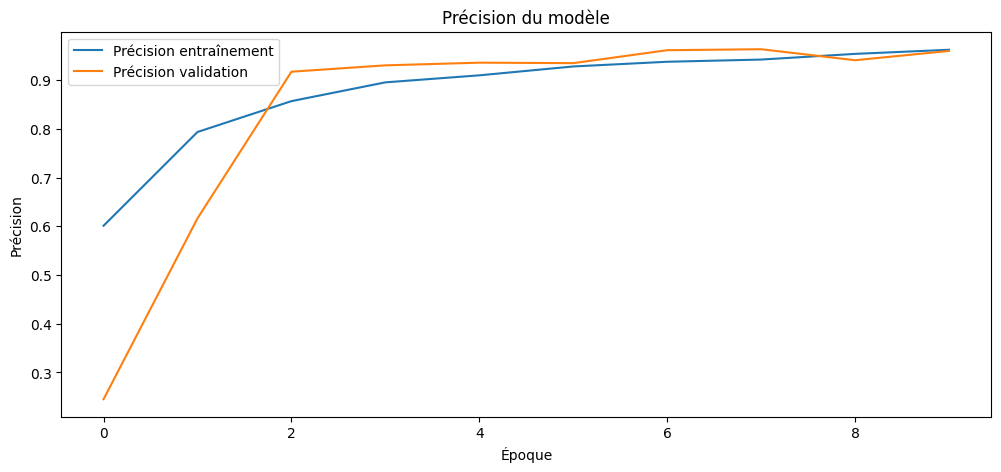

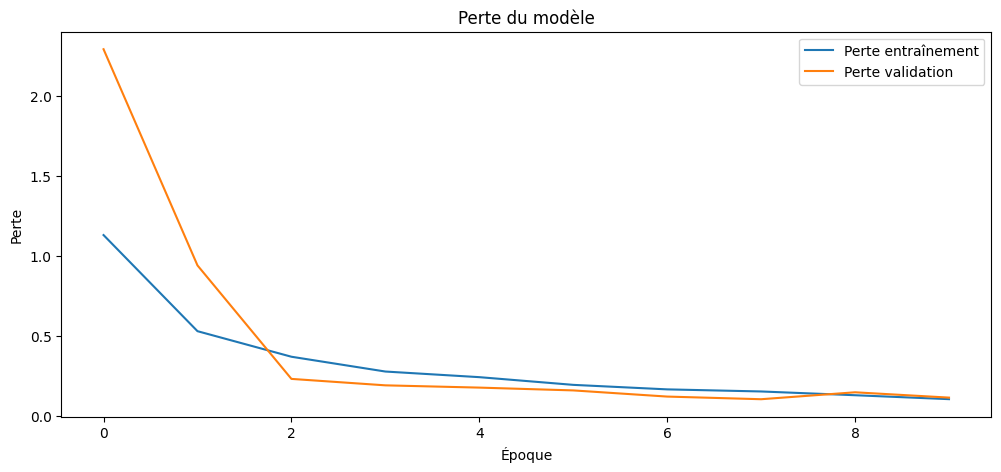

In [35]:
# Courbe de précision
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.title('Précision du modèle')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.show()

# Courbe de perte
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title('Perte du modèle')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.show()


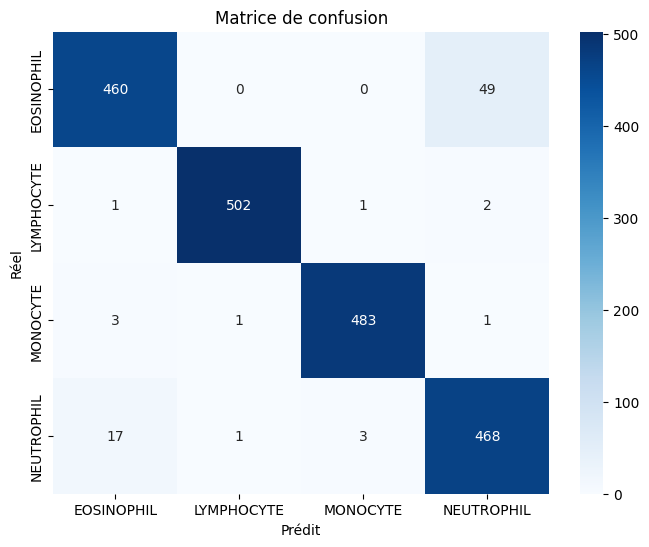

In [36]:
# Génération de la matrice de confusion
cm = confusion_matrix(true_labels, pred_labels, labels=list(labels_map.values()))

# Affichage
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(labels_map.values()),
            yticklabels=list(labels_map.values()))
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()


La précision et la perte en entraînement et validation montrent une convergence stable, proche des valeurs idéales, indiquant que le modèle généralise bien sans surapprentissage. Le rapport de classification confirme cette performance avec une précision globale élevée, notamment des scores F1 excellents pour les classes lymphocyte et monocyte (0.99). Contrairement à un modèle précédent, les classes éosinophile et neutrophile atteignent ici des scores de rappel solides (0.94 et 0.94 respectivement), montrant une amélioration notable dans leur détection.

# 3 ÉVALUATION DES MODÈLES

Après avoir effectué une évaluation qualitative pour chaque modèle, nous réalisons une évaluation quantitative afin de déterminer lequel offre les meilleures performances. Cette analyse comparative nous permettra de choisir le modèle le plus adapté pour notre tâche de classification.

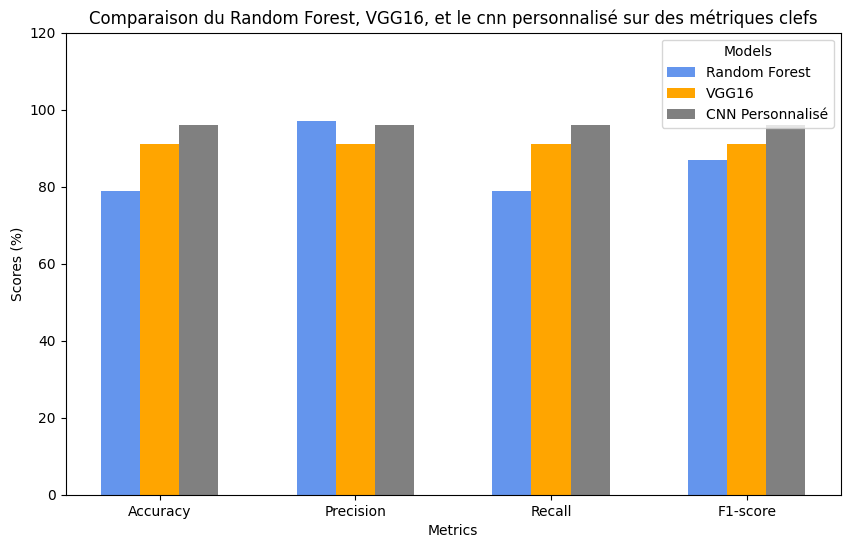

In [37]:
# Modèles et leurs valeurs pour chaque métrique en pourcentage
models = ["Random Forest", "VGG16", "CNN Personnalisé"]
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

# Nous entrons manuellement les valeurs pour chaque modèles étant donné qu'ils ont été exécuté à des moments différents
values = {
    "Accuracy": [79, 91, 96],
    "Precision": [97, 91, 96],
    "Recall": [79, 91, 96],
    "F1-score": [87, 91, 96]
}

x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['cornflowerblue', 'orange', 'gray']
for i, model in enumerate(models):
    metric_values = [values[metric][i] for metric in metrics]
    ax.bar(x + i * width, metric_values, width, label=model, color=colors[i])

ax.set_xlabel("Metrics")
ax.set_ylabel("Scores (%)")
ax.set_title("Comparaison du Random Forest, VGG16, et le cnn personnalisé sur des métriques clefs")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 120)
ax.legend(title="Models", loc="upper right")

plt.show()


Les résultats montrent une nette tendance en faveur du CNN personnalisé, qui domine sur toutes les métriques clés, atteignant des performances bonnes et équilibrées. VGG16 suit avec des bons scores également mais légèrement inférieurs, tandis que le Random Forest, bien qu'efficace dans certains cas, affiche une performance globale plus faible. 

En ce qui concerne la **précision**, le Random Forest se distingue avec un score de 97 %, le plus élevé parmi les modèles. Cette performance indique que, lorsqu'il identifie une classe, il est presque toujours correct, minimisant ainsi les faux positifs. Toutefois, cette force en précision est contrebalancée par des scores nettement plus faibles en rappel, ce qui suggère qu'il ne parvient pas à capturer tous les cas positifs.

# 4 CONCLUSION

Les trois modèles testés (Random Forest, VGG16 fine-tuned et CNN personnalisé) montrent des performances différentes pour la classification des images de globules blancs. Le Random Forest, bien qu'affichant une précision notablement élevée (97 %), montre des limitations importantes en rappel (79 %), suggérant qu'il ne parvient pas à capturer toute la complexité des différentes classes, en particulier pour des types visuellement similaires comme les monocytes et les neutrophiles. ¨Par ailleurs, le modèle VGG16 fine-tuned propose une performance équilibrée (91 % pour toutes les métriques), mais reste en deçà du CNN personnalisé, ce qui peut s'expliquer par une architecture moins spécifiquement ajustée à la tâche.

Le CNN personnalisé se démarque par une excellente performance sur l'ensemble des métriques, avec des scores élevés et cohérents (96 % pour l'accuracy, la précision, le rappel et le F1-score). Cette performance illustre sa capacité à extraire efficacement des caractéristiques complexes des images, notamment pour les classes les plus difficiles comme les éosinophiles et neutrophiles. 

En résumé, ce projet montre que, parmi les modèles évalués, le CNN personnalisé est le plus adapté à la classification des globules blancs. Il offre non seulement une meilleure précision globale mais aussi une capacité accrue à généraliser et capturer la diversité des classes, rendant son utilisation particulièrement pertinente dans un contexte médical.


Pour améliorer les performances des modèles, une approche d’ensemble (Ensemble Learning) pourrait être employée en combinant les prédictions des différents modèles (RF, VGG16 et CNN personnalisé) pour tirer parti des forces de chacun et obtenir des prédictions plus robustes. Un fine-tuning plus poussé du VGG16 sur des couches plus profondes, avec un taux d’apprentissage réduit, permettrait d’affiner ses capacités de classification pour les classes plus complexes, comme les éosinophiles et les neutrophiles. On pourrait également utilisatiser de techniques de rééchantillonnage, en augmentant la représentation des classes minoritaires, pourrait renforcer l’équilibre des prédictions et améliorer les scores de rappel pour les classes moins bien identifiées.